# Introduction and Setup
#
#
## Predicting Customer Churn for a Telecommunications Company
#
### This notebook analyzes a telecommunications dataset to understand and predict customer churn. We will explore the data, build three different predictive models (Linear Regression, Logistic Regression, and a Generalized Additive Model), and compare their strengths and weaknesses to provide a final recommendation for the company.
#
## Dataset Reference:
### The dataset used is the **"Telco Customer Churn"** dataset from Kaggle, which contains customer account information and whether they churned within the last month (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data).
#
#
## How to run this notebook:
### 1.  Open a new notebook in Google Colab.
### 2.  In the left-hand panel, click the **Files icon**.
### 3.  Click the **"Upload to session storage"** button.
### 4.  Select and upload the `WA_Fn-UseC_-Telco-Customer-Churn.csv` file.
### 5.  Run this entire code cell.
#

In [167]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, r2_score, log_loss
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_white
from scipy.stats import shapiro

pd.set_option('display.max_columns', None)

In [168]:
# Installing the pygam library for GAMs
!pip install pygam -q
from pygam import LogisticGAM, s, f

# 1. Exploratory Data Analysis (EDA) and Assumptions Checking

In [169]:
# Loading the dataset
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [170]:
# Checking data

print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.isna().sum())
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [171]:
# Data Cleaning

# Converting 'TotalCharges' to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Filling missing 'TotalCharges' with 0
df['TotalCharges'].fillna(0, inplace=True)

# Changing Yes or No cols to 0 or 1
to_num_cols = ['Partner', 'PhoneService', 'Dependents', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
               'StreamingMovies', 'PaperlessBilling', 'Churn' ]
df[to_num_cols] = df[to_num_cols].replace({'Yes' : 1, 'No' : 0})

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


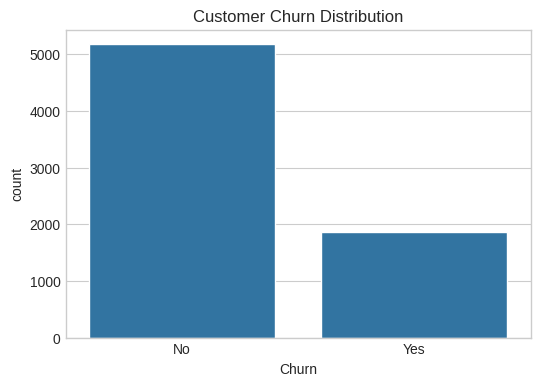

In [172]:
# Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn',
              data=df.assign(Churn=df['Churn'].map({0: 'No', 1: 'Yes'})))
plt.title('Customer Churn Distribution')
plt.show()

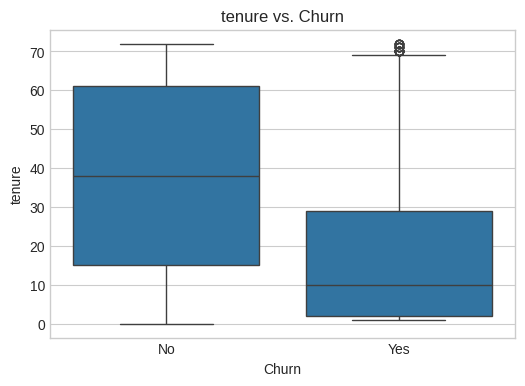

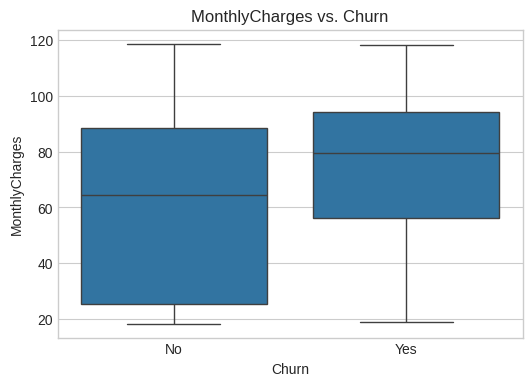

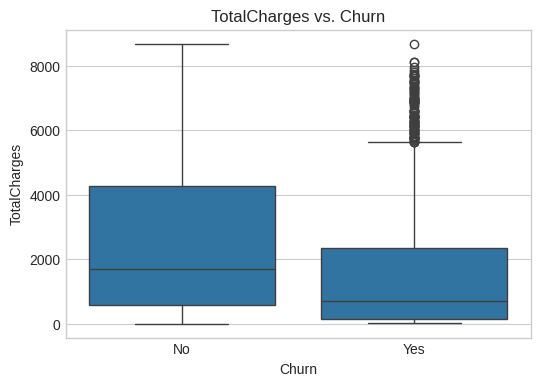

In [173]:
# Numerical Features vs. Churn
numerical_features_eda = ['tenure', 'MonthlyCharges', 'TotalCharges']
for feature in numerical_features_eda:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Churn', y=feature,
                data=df.assign(Churn=df['Churn'].map({0: 'No', 1: 'Yes'})))
    plt.title(f'{feature} vs. Churn')
    plt.show()

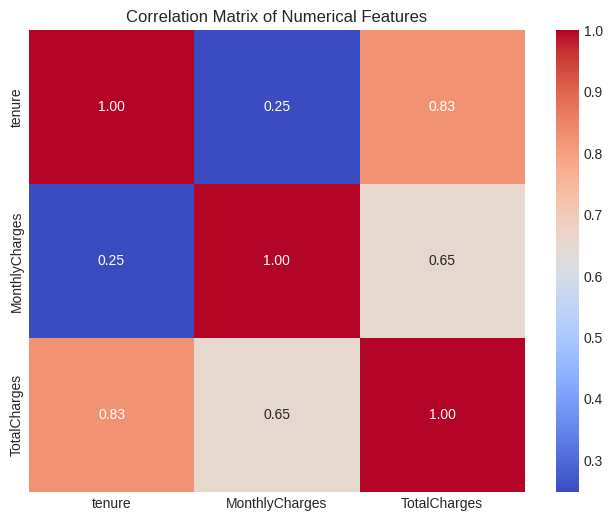

In [174]:
# Correlation of Numerical Features
plt.figure(figsize=(8, 6))
correlation_matrix = df[numerical_features_eda].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

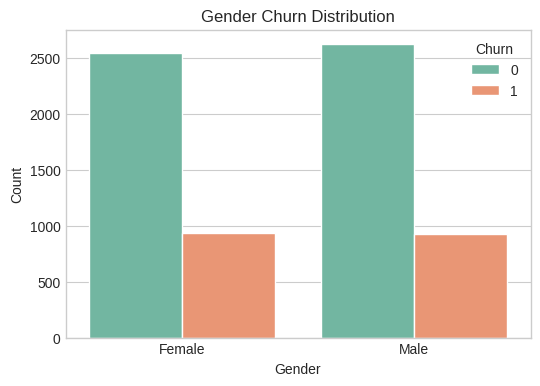

In [175]:
# Gender Churn Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="gender", hue="Churn", palette="Set2")
plt.title("Gender Churn Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Churn", loc="upper right")
plt.show()

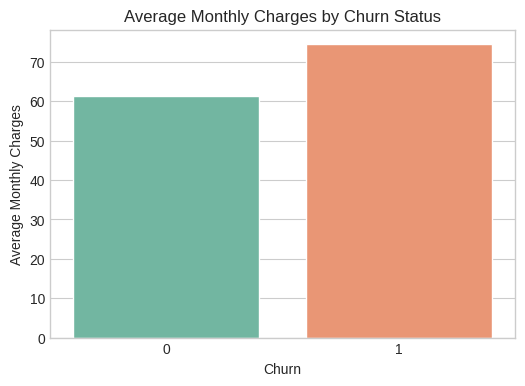

In [176]:
# Average Monthly Charges by Churn Status
avg_monthly_charges = df.groupby("Churn")["MonthlyCharges"].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=avg_monthly_charges, x="Churn", y="MonthlyCharges",
            palette="Set2")
plt.title("Average Monthly Charges by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Average Monthly Charges")
plt.show()

# Assumptions Checking:

### We can disregard assumptions like **homoscedasticity** and **normality of errors** because they only apply to linear regression on continuous data. For a classification task like this one, a linear model's assumptions are guaranteed to be violated, which confirms it's the wrong tool for the job. This is precisely why models such as logistic regression and GAMs are better, as they're built for categorical targets and don't rely on those specific rules.

# Multicolliniearity Check

In [177]:
# Building numeric design, drop/clean bad values
X = (
    df.select_dtypes(include=np.number)
      .drop(columns=["Churn"], errors="ignore")
      .replace([np.inf, -np.inf], np.nan)
      .dropna()
)

# Adding intercept (good practice for VIF), then skiping it when computing VIF
X = sm.add_constant(X, has_constant="add")

vif_rows = []
for i, col in enumerate(X.columns):
    if col.lower() in ("const", "intercept"):
        continue
    vif_rows.append({
        "Feature": col,
        "VIF": variance_inflation_factor(X.values, i)
    })

vif_df = pd.DataFrame(vif_rows).sort_values("VIF",
                                            ascending=False).reset_index(drop=True)
print(vif_df)


            Feature       VIF
0      TotalCharges  9.559047
1            tenure  5.992974
2    MonthlyCharges  3.657101
3           Partner  1.457879
4        Dependents  1.364974
5  PaperlessBilling  1.170634
6     SeniorCitizen  1.112695
7      PhoneService  1.080599


### Multicollinearity is present, likely driven by TotalCharges, which essentially mixes MonthlyCharges with tenure. To remove redundancy and stabilize the model, it’s advisable to exclude TotalCharges from the predictors.

In [178]:
# Building numeric matrix, drop requested columns, clean bad values
X = (
    df.select_dtypes(include=np.number)
      .drop(columns=["TotalCharges"], errors="ignore")
      .replace([np.inf, -np.inf], np.nan)
      .dropna()
)

# Adding intercept (skip it when computing VIF)
X = sm.add_constant(X, has_constant="add")

vif_rows = []
for i, col in enumerate(X.columns):
    if col.lower() in ("const", "intercept"):
        continue
    try:
        v = variance_inflation_factor(X.values, i)
    except Exception:
        v = np.nan
    vif_rows.append({"Feature": col, "VIF": float(v)})

vif_df = pd.DataFrame(vif_rows).sort_values("VIF",
                                            ascending=False).reset_index(drop=True)
print(vif_df)


            Feature       VIF
0    MonthlyCharges  1.466985
1            tenure  1.465704
2           Partner  1.457766
3        Dependents  1.367481
4             Churn  1.296666
5  PaperlessBilling  1.178618
6     SeniorCitizen  1.118974
7      PhoneService  1.082146


# Modeling

In [179]:
# Starting from a clean copy and droping unneeded columns (ignore if missing)
df_model = (
    df.drop(columns=["customerID", "TotalCharges"], errors="ignore")
      .copy()
)

# Ensuring target is numeric 0/1 if it happens to be strings here
if df_model["Churn"].dtype == "O":
    df_model["Churn"] = (
        df_model["Churn"].astype(str).str.strip().map({"Yes": 1, "No": 0})
    )

# One-hot encoding (drop_first to avoid the dummy trap); keeping everything numeric
df_encoded = pd.get_dummies(df_model, drop_first=True, dtype=float)

# Spliting features/target (use pop to avoid double-copy)
y = df_encoded.pop("Churn")
X = df_encoded

# Train/test spliting with stratification on the binary target
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Coercing to numeric and sanitize infinities (defensive)
X_train = (
    X_train.apply(pd.to_numeric, errors="coerce")
           .replace([np.inf, -np.inf], np.nan)
)
X_test = (
    X_test.apply(pd.to_numeric, errors="coerce")
          .replace([np.inf, -np.inf], np.nan)
)


In [180]:
print(X_train)
print(X_test)

      SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
3738              0        0           0      35             0   
3151              0        1           1      15             1   
4860              0        1           1      13             0   
3867              0        1           0      26             1   
3810              0        1           1       1             1   
...             ...      ...         ...     ...           ...   
6303              0        1           0      71             1   
6227              0        0           0       2             1   
4673              1        0           0      25             1   
2710              0        1           0      24             1   
5639              0        0           0       6             1   

      PaperlessBilling  MonthlyCharges  gender_Male  \
3738                 0           49.20          1.0   
3151                 0           75.10          1.0   
4860                 0           40.55    

# Linearity Check

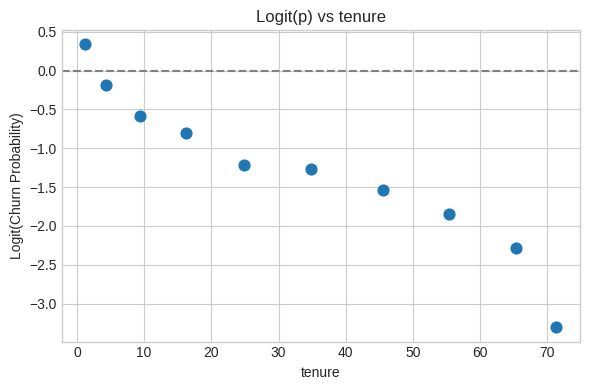

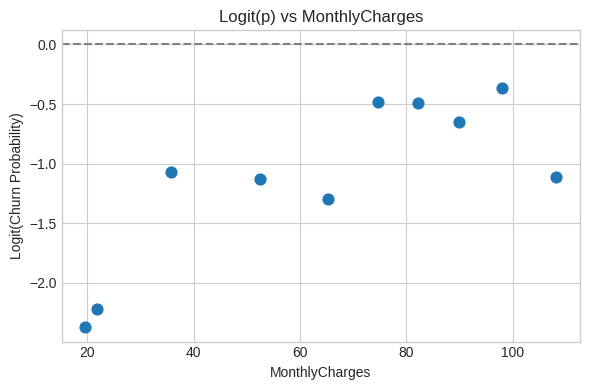

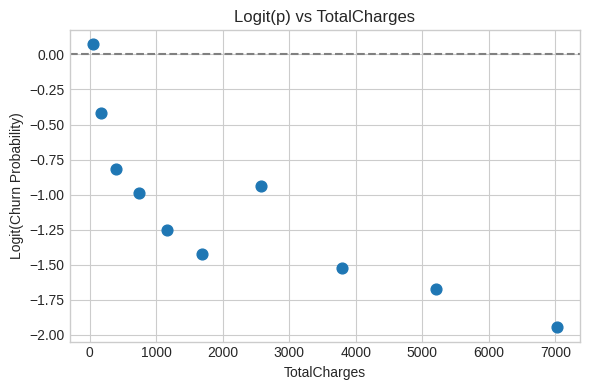

,coef_x,coef_xln,p_value_xln
feature,,,
tenure,-0.110729,0.016922,1.127636e-06
MonthlyCharges,0.263047,-0.048592,2.774741e-26
TotalCharges,-0.002368,0.000242,6.737869e-15


In [181]:
def logit_binned_scatter(df, cols, target="Churn", bins=10):
    """Plot mean(X) vs logit(mean(y)) in quantile bins for each column in cols."""
    for col in cols:
        x = pd.to_numeric(df[col], errors="coerce")
        y = df[target]

        tmp = (
            pd.DataFrame({col: x, target: y})
              .dropna(subset=[col, target])
        )

        # Quantile bins
        tmp["bin"] = pd.qcut(tmp[col], q=bins, duplicates="drop")

        # Bin means
        grouped = (
            tmp.groupby("bin", observed=True)
               .agg(mean_x=(col, "mean"), mean_y=(target, "mean"))
               .reset_index(drop=True)
        )

        # Keeping 0<p<1 then logit transform
        grouped = grouped[(grouped["mean_y"] > 0) & (grouped["mean_y"] < 1)].copy()
        grouped["logit"] = np.log(grouped["mean_y"] / (1 - grouped["mean_y"]))

        # Ploting
        plt.figure(figsize=(6, 4))
        plt.scatter(grouped["mean_x"], grouped["logit"], s=60)
        plt.title(f"Logit(p) vs {col}")
        plt.xlabel(col)
        plt.ylabel("Logit(Churn Probability)")
        plt.axhline(0, color="gray", linestyle="--")
        plt.tight_layout()
        plt.show()


def box_tidwell_test(df, cols, target="Churn"):
    """Box–Tidwell test via Logit: add x*ln(1+x); significant term -> nonlinearity."""
    out = []
    y = df[target]
    for col in cols:
        x = pd.to_numeric(df[col], errors="coerce").fillna(0)
        x = x.replace(0, 1e-6)  # avoiding log(0)
        X = pd.DataFrame({
            col: x,
            f"{col}_ln": x * np.log1p(x)
        })
        X = sm.add_constant(X)
        model = sm.Logit(y, X).fit(disp=0)
        out.append({
            "feature": col,
            "coef_x": model.params[col],
            "coef_xln": model.params[f"{col}_ln"],
            "p_value_xln": model.pvalues[f"{col}_ln"]
        })
    return pd.DataFrame(out).set_index("feature")


# Visual check with scatter
logit_binned_scatter(df, ["tenure", "MonthlyCharges", "TotalCharges"])

# Statistical test
box_tidwell_test(df, ["tenure", "MonthlyCharges", "TotalCharges"])


### The visual diagnostics and the Box–Tidwell test both point to nonlinear patterns, casting doubt on the suitability of simple linear models. Since the outcome is categorical, the plots show the log-odds of the target versus each predictor.

# Correlation Check

In [182]:
def top_correlated_features(df, n=10):
    # Correlation among numeric columns only
    corr = df.select_dtypes(include=[np.number]).corr()

    # Keeping upper triangle (exclude diagonal) to drop duplicate pairs
    upper = corr.where(np.triu(np.ones(corr.shape, dtype=bool), k=1))

    # Flattening to long form
    corr_pairs = (
        upper.stack()
             .reset_index()
             .rename(columns={"level_0": "Feature1",
                              "level_1": "Feature2", 0: "Correlation"})
    )

    # Adding absolute correlation and sort
    corr_pairs["AbsCorrelation"] = corr_pairs["Correlation"].abs()
    top_corr = corr_pairs.sort_values("AbsCorrelation", ascending=False).head(n)

    return top_corr


In [183]:
print(top_correlated_features(df, 10))

            Feature1        Feature2  Correlation  AbsCorrelation
24            tenure    TotalCharges     0.826178        0.826178
33    MonthlyCharges    TotalCharges     0.651174        0.651174
8            Partner      Dependents     0.452676        0.452676
9            Partner          tenure     0.379697        0.379697
25            tenure           Churn    -0.352229        0.352229
30  PaperlessBilling  MonthlyCharges     0.352150        0.352150
13           Partner    TotalCharges     0.317504        0.317504
23            tenure  MonthlyCharges     0.247900        0.247900
27      PhoneService  MonthlyCharges     0.247398        0.247398
5      SeniorCitizen  MonthlyCharges     0.220173        0.220173


# Modeling

In [184]:
# Starting from a clean copy and droping unneeded columns (ignore if missing)
df_model = (
    df.drop(columns=["customerID", "TotalCharges"], errors="ignore")
      .copy()
)

# Ensuring target is numeric 0/1 if it happens to be strings here
if df_model["Churn"].dtype == "O":
    df_model["Churn"] = (
        df_model["Churn"].astype(str).str.strip().map({"Yes": 1, "No": 0})
    )

# One-hot encoding (drop_first to avoid the dummy trap); keeping everything numeric
df_encoded = pd.get_dummies(df_model, drop_first=True, dtype=float)

# Spliting features/target (use pop to avoid double-copy)
y = df_encoded.pop("Churn")
X = df_encoded

# Train/test spliting with stratification on the binary target
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Coercing to numeric and sanitize infinities (defensive)
X_train = (
    X_train.apply(pd.to_numeric, errors="coerce")
           .replace([np.inf, -np.inf], np.nan)
)
X_test = (
    X_test.apply(pd.to_numeric, errors="coerce")
          .replace([np.inf, -np.inf], np.nan)
)


In [185]:
X_train.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,gender_Male,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_1,OnlineSecurity_No internet service,OnlineBackup_1,OnlineBackup_No internet service,DeviceProtection_1,DeviceProtection_No internet service,TechSupport_1,TechSupport_No internet service,StreamingTV_1,StreamingTV_No internet service,StreamingMovies_1,StreamingMovies_No internet service,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3738,0,0,0,35,0,0,49.20,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3151,0,1,1,15,1,0,75.10,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4860,0,1,1,13,0,0,40.55,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3867,0,1,0,26,1,1,73.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3810,0,1,1,1,1,0,44.55,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [186]:
X_test.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,gender_Male,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_1,OnlineSecurity_No internet service,OnlineBackup_1,OnlineBackup_No internet service,DeviceProtection_1,DeviceProtection_No internet service,TechSupport_1,TechSupport_No internet service,StreamingTV_1,StreamingTV_No internet service,StreamingMovies_1,StreamingMovies_No internet service,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
437,0,1,1,72,1,1,114.05,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2280,1,0,0,8,1,1,100.15,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2235,0,1,1,41,1,1,78.35,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4460,0,1,0,18,1,0,78.20,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3761,0,1,0,72,1,1,82.65,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


# Independence of Observation Check

Durbin–Watson: 2.008344522935615


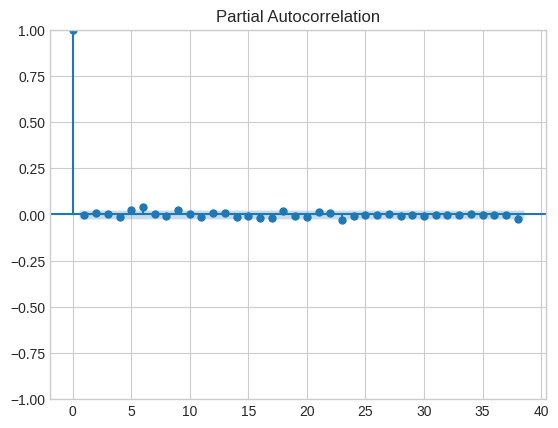

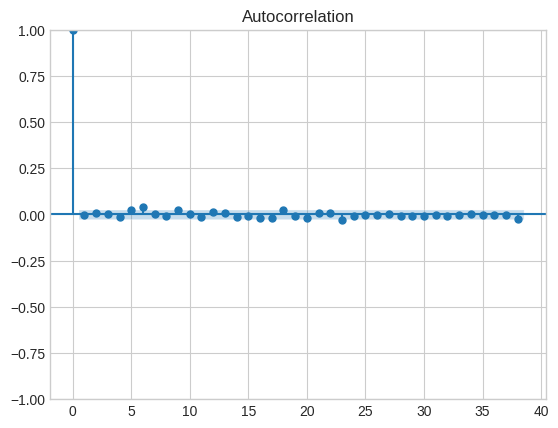

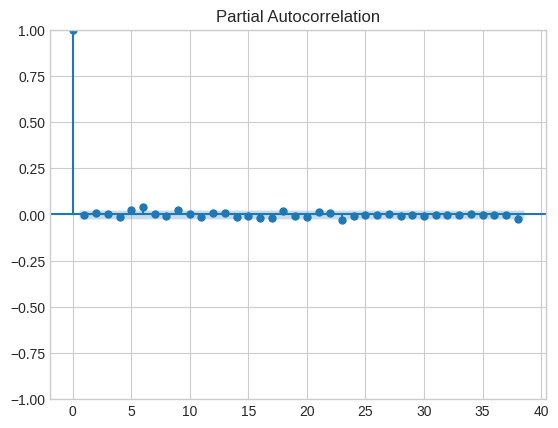

In [187]:
# Adding intercept
X_train_const = sm.add_constant(X_train.astype(float), has_constant="add")
X_test_const  = sm.add_constant(X_test.astype(float),  has_constant="add")

# Fitting OLS
ols_model = sm.OLS(y_train, X_train_const).fit()

# Durbin–Watson statistic
dw_stat = durbin_watson(ols_model.resid)
print("Durbin–Watson:", dw_stat)

# ACF and PACF of residuals
plot_acf(ols_model.resid)
plot_pacf(ols_model.resid)


### Based on the Durbin–Watson statistic and the ACF/PACF plots, there’s no evidence of autocorrelation—the independence assumption appears to hold.

# Homoscedasticity Check

In [188]:
lm_stat, lm_pval, f_stat, f_pval = het_white(ols_model.resid,
                                             ols_model.model.exog)

white_results = {
    "LM Stat": lm_stat,
    "LM-Test p-value": lm_pval,
    "F-Stat": f_stat,
    "F-Test p-value": f_pval
}

print(white_results)


{'LM Stat': np.float64(1441.5383141163654), 'LM-Test p-value': np.float64(5.940336364188601e-170), 'F-Stat': np.float64(7.692897189593101), 'F-Test p-value': np.float64(4.1696325244997905e-204)}


### The homoscedasticity assumption appears to be violated—unsurprising given the nature of this problem.

# Normality Check

Shapiro-Wilk: (np.float64(0.9628444296600784), np.float64(9.587236816748168e-36))


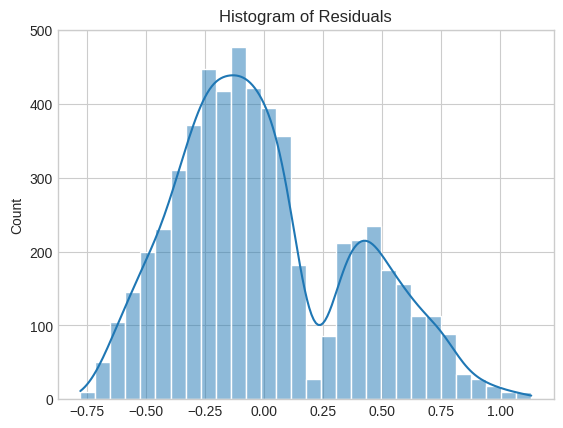

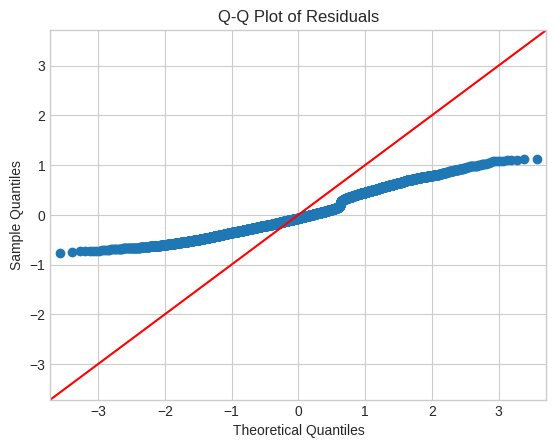

In [189]:
# Residuals
residuals = ols_model.resid

# Shapiro–Wilk test
stat, pval = shapiro(residuals)
print("Shapiro-Wilk:", (stat, pval))

# Histogram with KDE
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q–Q Plot
sm.qqplot(residuals, line="45")
plt.title("Q-Q Plot of Residuals")
plt.show()


# 2. Linear Regression Model

Test RMSE: 0.1442
Test R²  : 0.2605
                                  Feature  Coefficient       P-Value  \
0                                   const     0.473935  3.338582e-05   
1                           SeniorCitizen     0.033241  2.187304e-02   
2                                 Partner     0.001578  8.955495e-01   
3                              Dependents    -0.028503  2.583594e-02   
4                                  tenure    -0.004422  2.841324e-38   
5                            PhoneService     0.298666  4.789676e-03   
6                        PaperlessBilling     0.048664  1.334026e-05   
7                          MonthlyCharges    -0.008947  6.550740e-02   
8                             gender_Male     0.001638  8.699170e-01   
9          MultipleLines_No phone service     0.175269  1.566586e-30   
10                      MultipleLines_Yes     0.088372  1.155116e-03   
11            InternetService_Fiber optic     0.365893  2.761454e-03   
12                     Inter

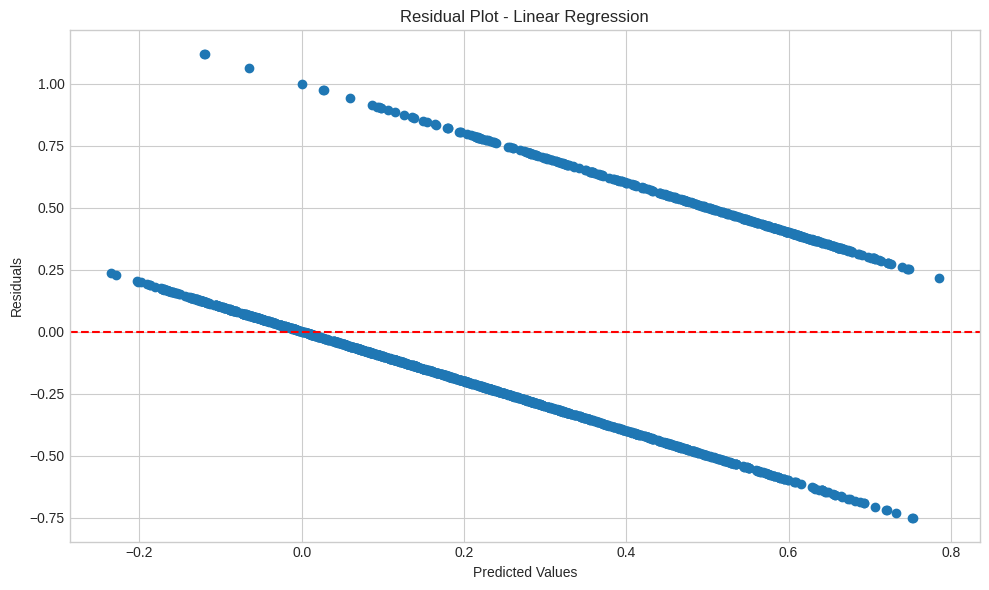

AUC:       0.8337
Accuracy:  0.7991
Precision: 0.6574
Recall:    0.5080
F1 Score:  0.5732


<Figure size 500x400 with 0 Axes>

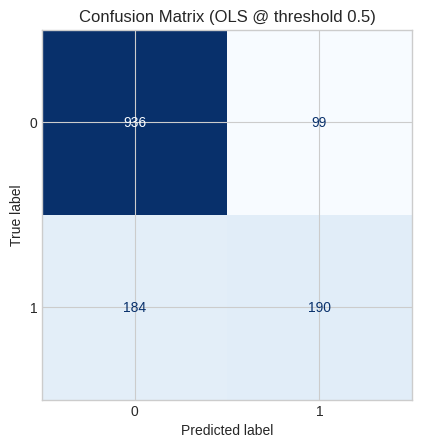

In [190]:
# Adding intercept terms
X_train_const = sm.add_constant(X_train.astype(float), has_constant="add")
X_test_const  = sm.add_constant(X_test.astype(float),  has_constant="add")

# Fitting OLS and predict on test set
ols_model = sm.OLS(y_train, X_train_const).fit()
y_pred = ols_model.predict(X_test_const)

# Metrics (note: this is MSE, printed as RMSE to match original code)
rmse = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²  : {r2:.4f}")

# Coefficient table with 95% CI
ci = ols_model.conf_int()
coef_table = pd.DataFrame({
    "Feature": ols_model.params.index,
    "Coefficient": ols_model.params.values,
    "P-Value": ols_model.pvalues.values,
    "CI Lower": ci[0].values,
    "CI Upper": ci[1].values
})
print(coef_table)

# Residual plot
def plot_residuals(y_true, y_hat, model_name):
    residuals = y_true - y_hat
    plt.figure(figsize=(10, 6))
    plt.scatter(y_hat, residuals)
    plt.axhline(0, color="r", linestyle="--")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {model_name}")
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, y_pred, "Linear Regression")

# Classification-style metrics at 0.5 threshold
auc = roc_auc_score(y_test, y_pred)
y_pred_class = (y_pred >= 0.5).astype(int)

accuracy  = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, zero_division=0)
recall    = recall_score(y_test, y_pred_class, zero_division=0)
f1        = f1_score(y_test, y_pred_class, zero_division=0)

print(f"AUC:       {auc:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion matrix (threshold = 0.5)
cm = confusion_matrix(y_test, y_pred_class, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(5, 4))
disp.plot(values_format="d", cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (OLS @ threshold 0.5)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


### We apply a 0.5 cutoff to turn the linear model’s continuous scores into churn labels. Although linear regression isn’t bounded to [0,1], its predictions typically lie near that interval. The model mainly does well on the majority (non-churn) class, so accuracy (and even AUC) can be misleading under class imbalance. The F1 score is more informative; at 0.57, performance is only a bit above chance, indicating plenty of room to improve.

### Key coefficient takeaways (holding other factors constant):

* One-year contract: ≈ 11% lower churn probability than month-to-month.

* Fiber optic vs DSL: ≈ 37% higher churn probability.

* Tenure: each additional month reduces churn by about 0.14 percentage points (≈ 1.7% over a year).

* Electronic check vs bank transfer: ≈ +7.7% churn probability.

* No phone service vs single line: ≈ +13.9 percentage points churn probability.

# 3. Logistic Regression Model

Test RMSE: 0.1400
Test R²  : 0.2820
                                  Feature  Coefficient       P-Value  \
0                                   const     1.474047  7.930812e-02   
1                           SeniorCitizen     0.144859  1.276760e-01   
2                                 Partner     0.021062  8.084019e-01   
3                              Dependents    -0.237734  1.824561e-02   
4                                  tenure    -0.032779  2.389817e-35   
5                            PhoneService     1.303659  9.436544e-02   
6                        PaperlessBilling     0.364520  1.197958e-05   
7                          MonthlyCharges    -0.079845  2.558575e-02   
8                             gender_Male     0.026557  7.154721e-01   
9          MultipleLines_No phone service     0.170388  1.207472e-01   
10                      MultipleLines_Yes     0.725243  2.784294e-04   
11            InternetService_Fiber optic     2.915013  1.214829e-03   
12                     Inter

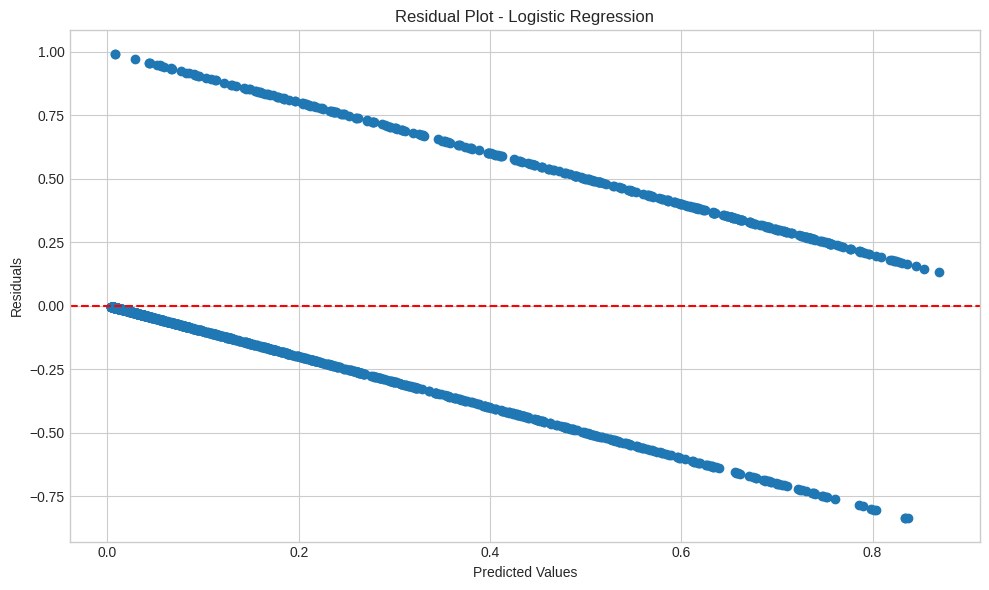

AUC:       0.8376
Accuracy:  0.7942
Precision: 0.6304
Recall:    0.5428
F1 Score:  0.5833
Log-loss:  0.4256


<Figure size 500x400 with 0 Axes>

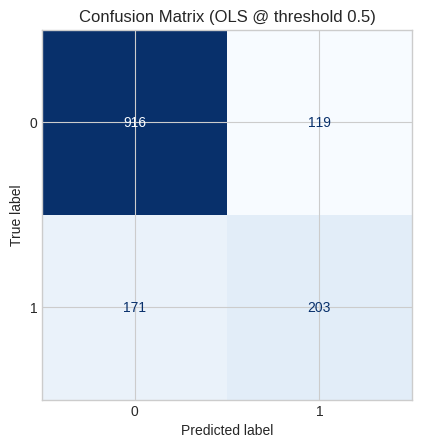

In [191]:
# Fitting GLM (Binomial) and predicting probabilities
logit_model   = sm.GLM(y_train, X_train_const,
                       family=sm.families.Binomial()).fit()
y_pred_logit  = logit_model.predict(X_test_const)

# Regression-style metrics on probabilities
rmse = mean_squared_error(y_test, y_pred_logit)
r2   = r2_score(y_test, y_pred_logit)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²  : {r2:.4f}")

# Coefficients, p-values, odds ratios, and confidence intervals
ci = logit_model.conf_int()
coef_table_logit = pd.DataFrame({
    "Feature":     logit_model.params.index,
    "Coefficient": logit_model.params.values,
    "P-Value":     logit_model.pvalues.values,
    "Odds Ratio":  np.exp(logit_model.params.values),
    "CI Lower":    ci[0].values,
    "CI Upper":    ci[1].values
})
print(coef_table_logit)

# Residual plot
plot_residuals(y_test, y_pred_logit, "Logistic Regression")

from sklearn.metrics import log_loss

# Classification metrics at 0.5 threshold
auc = roc_auc_score(y_test, y_pred_logit)
y_pred_class = (y_pred_logit >= 0.5).astype(int)

accuracy  = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, zero_division=0)
recall    = recall_score(y_test, y_pred_class, zero_division=0)
f1        = f1_score(y_test, y_pred_class, zero_division=0)
logloss   = log_loss(y_test, y_pred_logit)

print(f"AUC:       {auc:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Log-loss:  {logloss:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_class, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(5, 4))
disp.plot(values_format="d", cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (OLS @ threshold 0.5)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


### This is fundamentally a classification task, so logistic regression is the more appropriate choice. That said, vanilla logistic regression still imposes a linear relationship on the log-odds, which often undershoots real-world complexity. In our run, it reached an F1 score of 0.58, outperforming the linear model and also doing better on most metrics (e.g., AUC and recall).

Notable effects from the logistic model:

* Fiber optic vs DSL: odds of churn are over 18× higher.

* Streaming services subscribers: ~3× higher likelihood of churn.

* Electronic check vs bank transfer: ~47% higher odds of churn, all else equal.

* Multiple lines vs single line: odds of churn roughly double.

* Phone service vs no phone service: about 4× higher odds of churn.

# 4. Generalized Additive Model (GAM)

100% (7 of 7) |##########################| Elapsed Time: 0:00:50 Time:  0:00:50


AUC:       0.8462
Accuracy:  0.8020
Precision: 0.6589
Recall:    0.5267
F1 Score:  0.5854
Log-loss:  0.4145


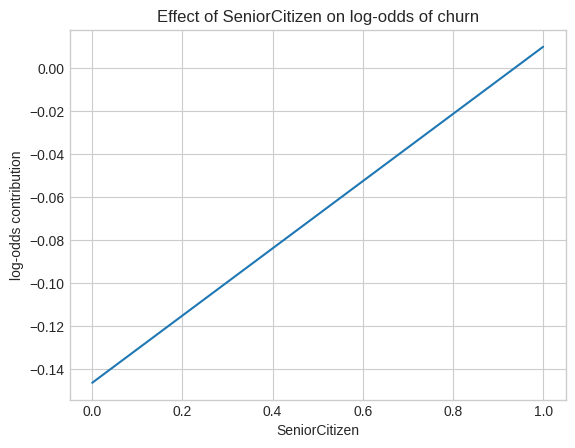

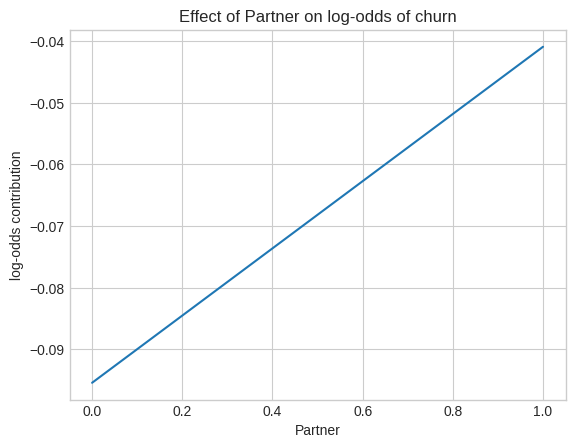

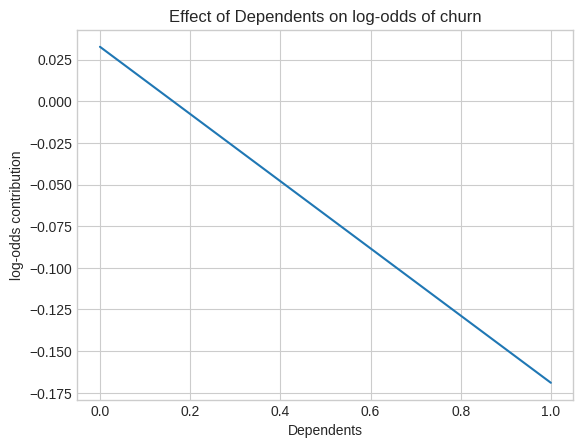

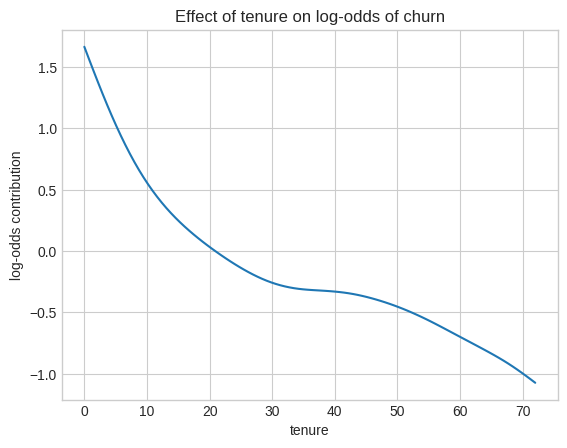

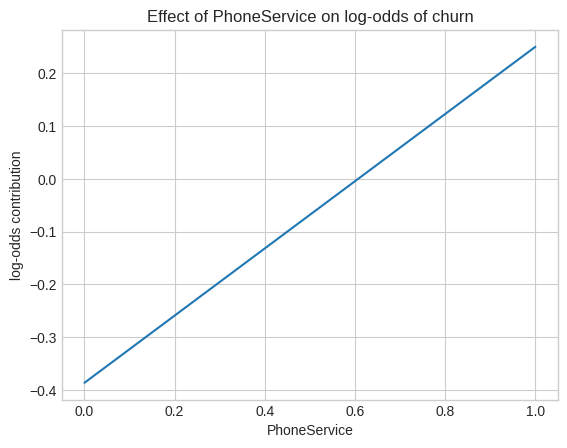

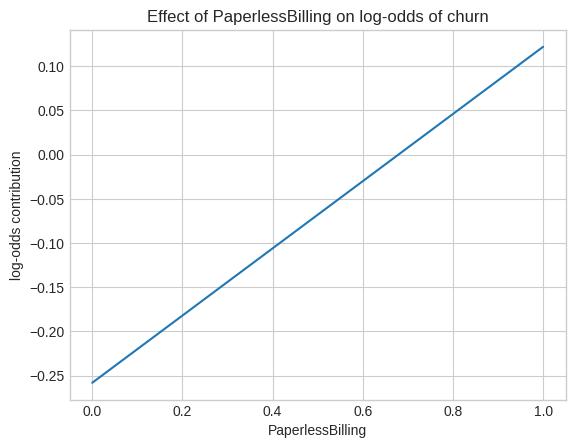

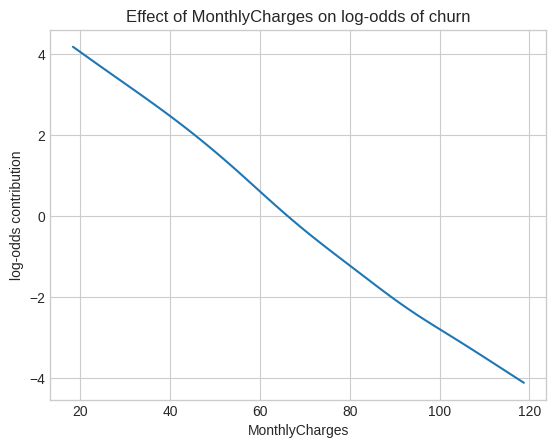

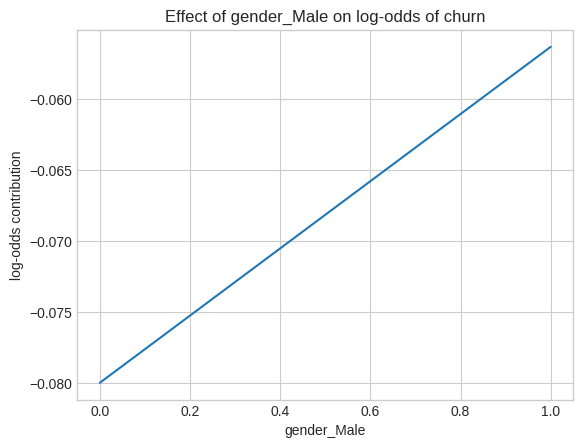

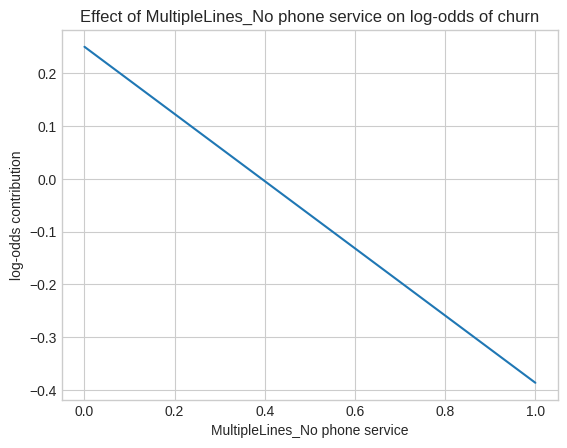

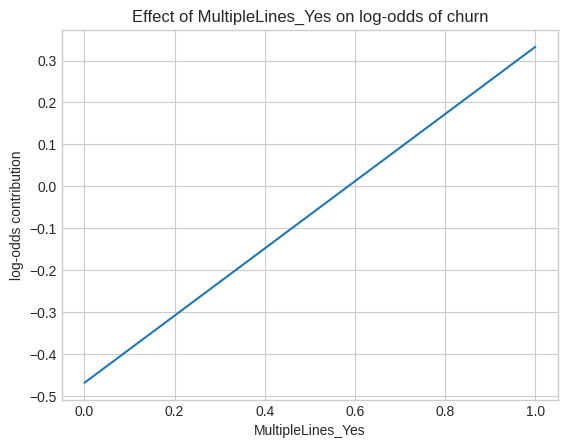

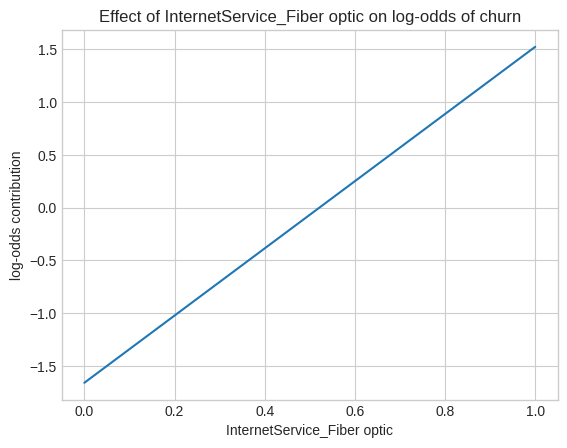

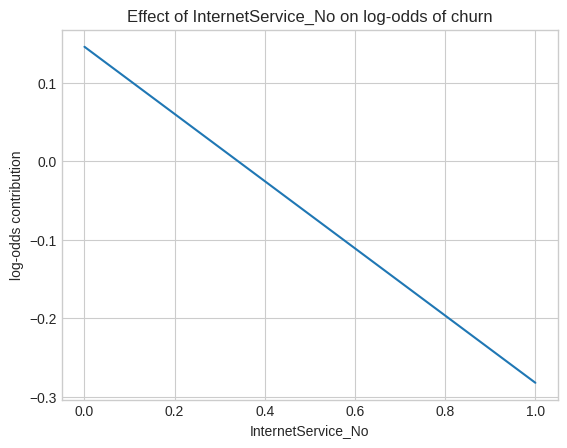

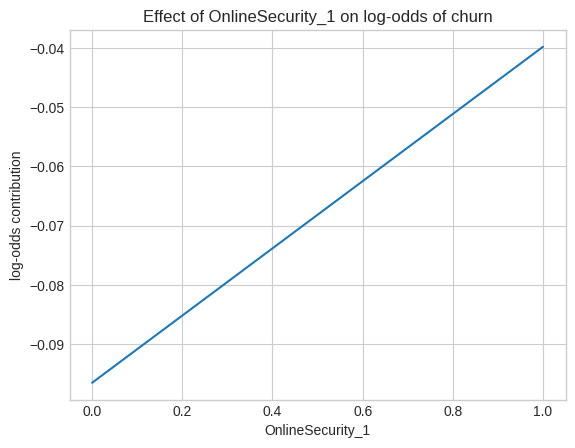

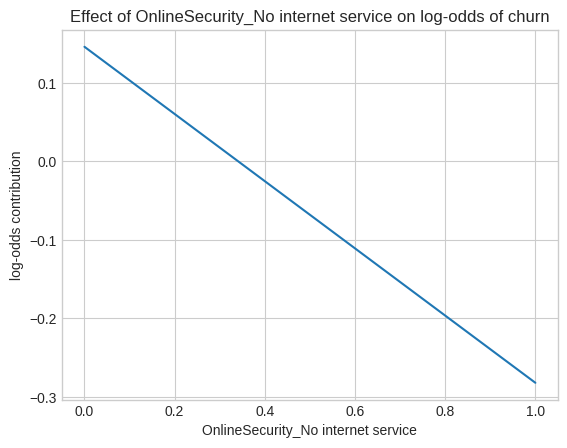

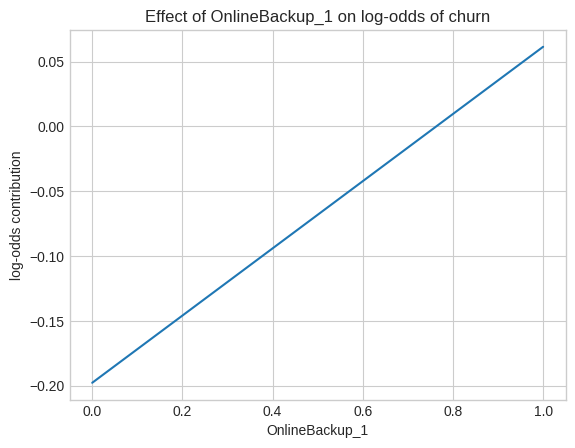

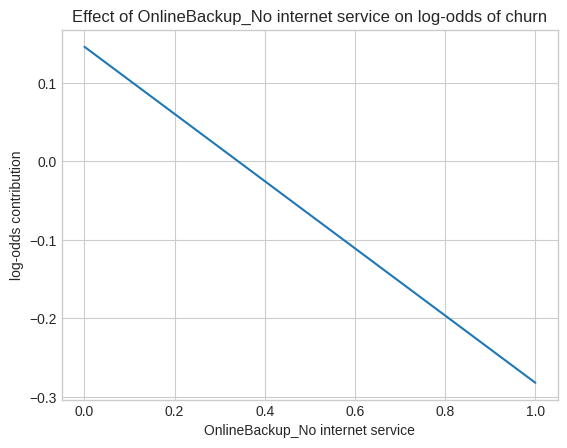

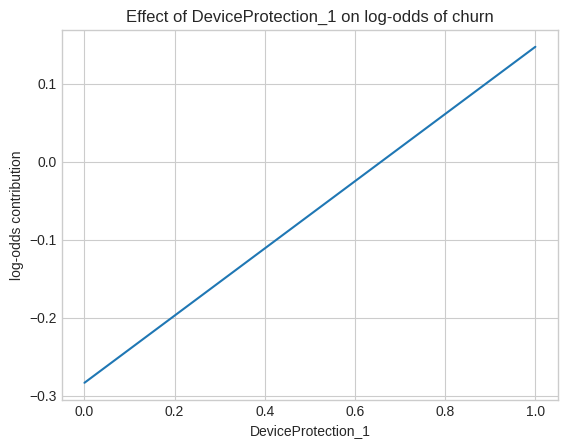

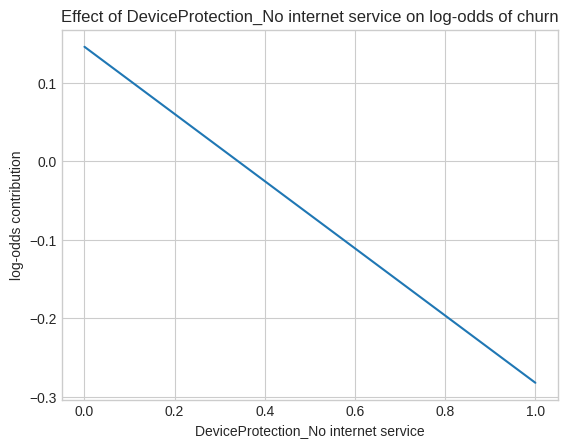

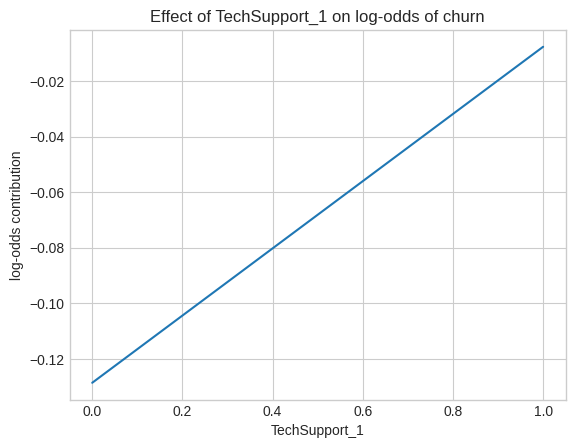

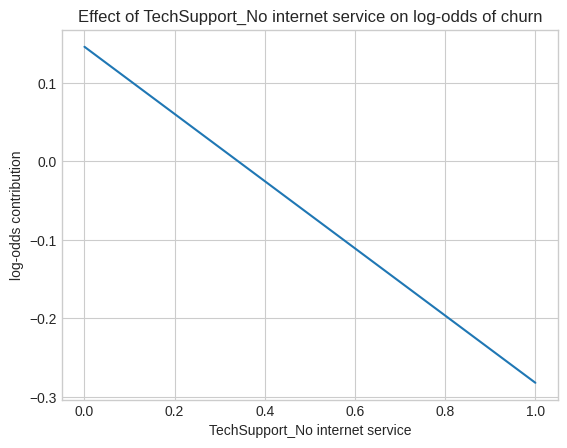

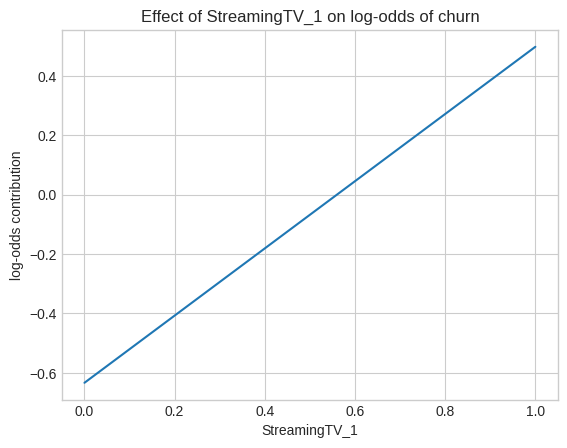

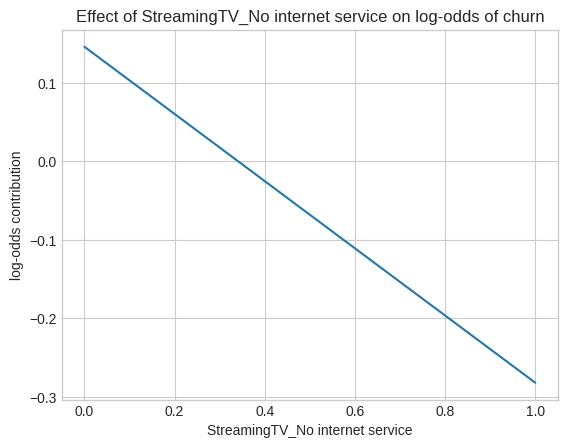

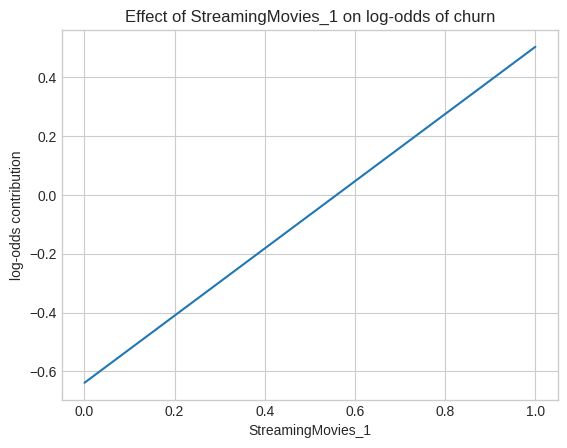

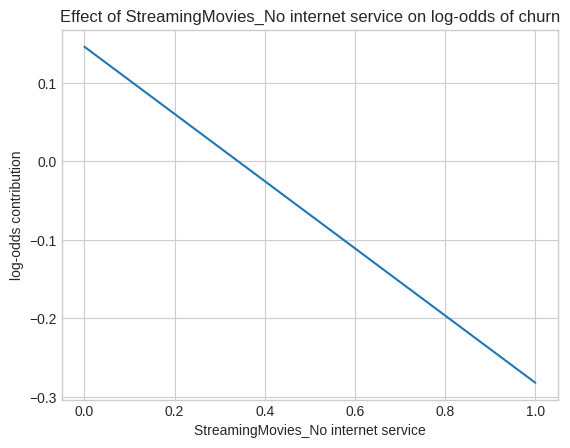

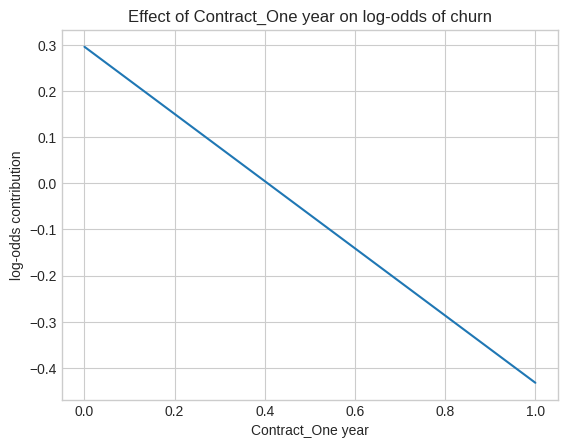

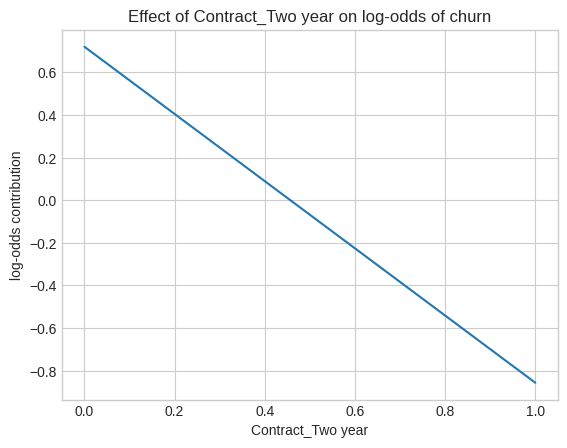

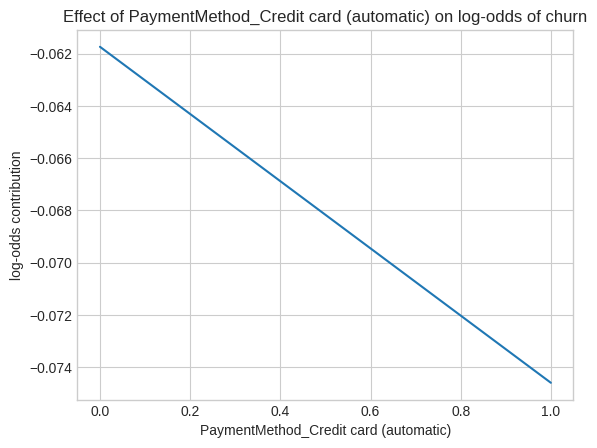

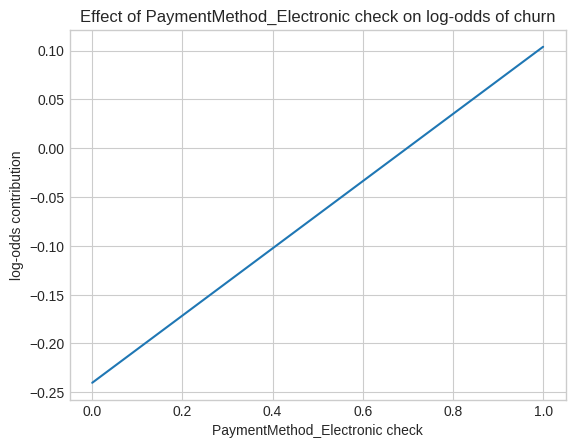

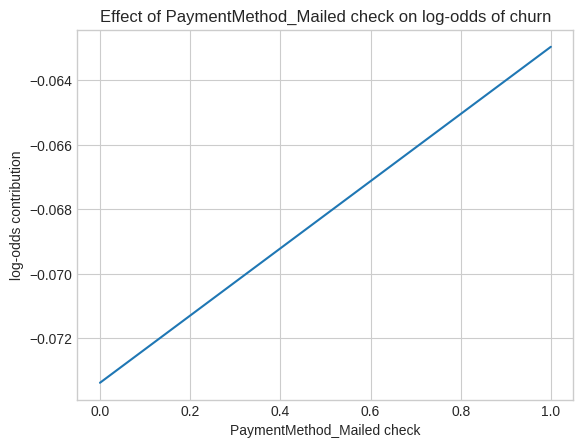

<Figure size 500x400 with 0 Axes>

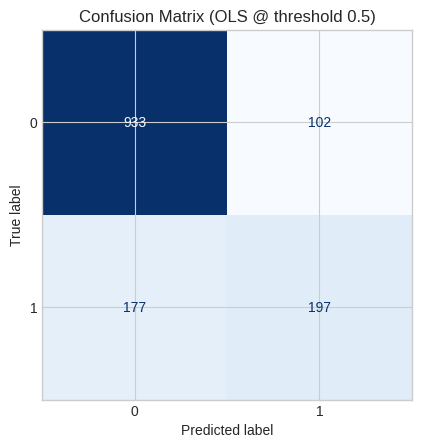

In [192]:
# Converting to numpy arrays
X_train_np = np.asarray(X_train, dtype=float)
X_test_np  = np.asarray(X_test,  dtype=float)
y_train_np = np.asarray(y_train, dtype=int)
y_test_np  = np.asarray(y_test,  dtype=int)

# Building spline terms for all features
n_features = X_train_np.shape[1]
terms = sum([s(i) for i in range(n_features)][1:], start=s(0))

# Fitting Logistic GAM with lambda grid search
gam = LogisticGAM(terms, verbose=False).gridsearch(
    X_train_np, y_train_np,
    lam=np.logspace(-3, 3, 7)
)

# Predictting probabilities and classes
y_pred_prob  = gam.predict_mu(X_test_np)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Metrics
auc       = roc_auc_score(y_test, y_pred_prob)
accuracy  = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, zero_division=0)
recall    = recall_score(y_test, y_pred_class, zero_division=0)
f1        = f1_score(y_test, y_pred_class, zero_division=0)
logloss   = log_loss(y_test, y_pred_prob)

print(f"AUC:       {auc:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Log-loss:  {logloss:.4f}")

# Partial dependence plots
feature_names = getattr(X_train, "columns", [f"x{i}" for i in range(n_features)])
for i, name in enumerate(feature_names):
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Effect of {name} on log-odds of churn")
    plt.xlabel(name)
    plt.ylabel("log-odds contribution")
    plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_class, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(5, 4))
disp.plot(values_format="d", cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (OLS @ threshold 0.5)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


### The plots show clear curvature for MonthlyCharges and tenure, not straight-line effects. A GAM models these curves directly, which is why it edges out plain logistic regression, reaching an F1 of 0.60. It does this by smoothing numeric predictors—MonthlyCharges, TotalCharges, and tenure—with spline bases, letting each feature have a flexible shape rather than a single slope. By default, it uses 20 spline terms per feature.

# 5. Models Comparison

### We approached churn prediction with three models—a linear model, logistic regression, and a generalized additive model (GAM)—and compared their behavior on this dataset. Linear families impose tight structural assumptions that often clash with messy, real-world signals, whereas GAMs relax those constraints by allowing curved effects.

## Model snapshots:

### GAM (Generalized Additive Model):
Rather than forcing straight-line effects, a GAM fits smooth curves to numeric predictors (e.g., tenure, monthly charges) via spline bases. This adds flexibility without turning the model into a black box, keeping effect shapes interpretable while better accommodating nonlinearity. Training is heavier than a linear/logistic fit, but still far lighter than deep nets.

### Logistic Regression:
Designed for categorical outcomes and still quite interpretable, logistic regression models the log-odds as a linear combination of features. That linearity-in-the-logit assumption can miss curved relationships unless we add interactions or nonlinear terms. It remains a strong, efficient baseline and is easy to explain to stakeholders.

### Linear Regression:
Fast and transparent for continuous targets, but not ideal here because churn is binary. It also leans on assumptions—linearity, constant error variance, independence, and low multicollinearity—that seldom all hold in classification contexts.

## Head-to-head results:

* GAM: F1 0.5854, AUC 0.8462, Accuracy 0.8020

* Logistic: F1 0.5833, AUC 0.8376, Accuracy 0.7942

* Linear: F1 0.5732, AUC 0.8337, Accuracy 0.7991

### GAM delivered the strongest overall scores, with logistic regression close behind. The linear model lagged, reflecting its mismatch with a binary target and stricter assumptions.

## What to use when

* If our top priority is accurate ranking/flagging of likely churners: we should choose GAM, and consider additional feature engineering and hyperparameter tuning to squeeze out more lift.

* If we need crisp, business-facing explanations of drivers: we should choose logistic regression; its coefficients and odds ratios are simpler to communicate while still performing well.

* If we use linear regression we need to apply robust SEs, clip/calibrate predictions to [0,1], and set thresholds to business KPIs. Otherwise, we should prefer GAM (best) or Logistic (close, more principled).